In [22]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.optimizers import Adam
import keras.models as kmod
import scipy.signal as sig
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
import os
import timeit

In [23]:
!git clone https://github.com/eriknes/mcmc

fatal: destination path 'mcmc' already exists and is not an empty directory.


In [24]:
def wassersteinLoss(y_true, y_pred):
    """Wasserstein loss for a sample batch."""
    return K.mean(y_true * y_pred)

#generator = kmod.load_model('mcmc/models/delta_gen_3F_192px_lat32.h5', custom_objects={'wassersteinLoss': wassersteinLoss})
generator = kmod.load_model('mcmc/models/gen_lat32_192px_4f.h5', custom_objects={'wassersteinLoss': wassersteinLoss})
generator.summary()
randomDim = 32

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 36864)             1216512   
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 12, 12)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 256, 12, 12)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 256, 24, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 24, 24)       819328    
_________________________________________________________________
activation_2 (Activation)    (None, 128, 24, 24)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 128, 48, 48)      

Forward :  0.036491949999799544
SciPy FFT Convolution CPU time:  0.00820629200006806
SciPy Linear Convolution CPU time:  3.4696403380003176
TensorFlow Linear Convolution GPU time:  0.0008712069993634941


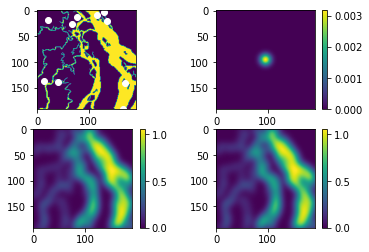

In [57]:

nHardDataPoints = 10
nx = 192

folder = 'mcmc/entireDeltas1/10wells'

os.chdir(folder)

bw = pd.read_csv('BW.csv', sep=',',header=None)

os.chdir('../../..')

sandBW    =  bw.values[0:196,0:196]

Ck = 50*np.eye(2)
mk = np.zeros(2,)
#x, y = np.mgrid[np.linspace(-51, 51, 101), np.linspace(-51, 51, 101)]

x, y = np.meshgrid(np.linspace(-91, 91, 192), np.linspace(-91, 91, 192))
gr = np.dstack((x, y))
mvn = multivariate_normal(mean = mk, cov = Ck)
kernel_np = mvn.pdf(gr)
kernel_tf = tf.constant(kernel_np[:,:,np.newaxis,np.newaxis], dtype=tf.float32)
start = timeit.default_timer()
sandBW_tf = tf.constant(sandBW[np.newaxis,:,:,np.newaxis], dtype=tf.float32)
soft_data_tf = tf.nn.conv2d(sandBW_tf, kernel_tf , strides = [1,1,1,1],  padding='SAME')
elapsed_time_4 = (timeit.default_timer() - start)

hardDataCoords = np.random.randint(0,nx,[nHardDataPoints,2])

plt.subplot(2,2,1)
plt.imshow(sandBW)
plt.plot(hardDataCoords[:,0],hardDataCoords[:,1],'wo')

plt.subplot(2,2,2)
plt.imshow(kernel_np)
plt.colorbar()


plt.subplot(2,2,3)
plt.imshow(sig.fftconvolve(sandBW, kernel_np, mode='same'))
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(soft_data_tf[0,:,:,0])
plt.colorbar()

start = timeit.default_timer()
noise1 = np.random.normal(0, 1, size=[1, randomDim])
generatedImages = generator.predict(noise1)
elapsed_time_1 = (timeit.default_timer() - start)
print('Forward : ', elapsed_time_1)

start = timeit.default_timer()
sig.fftconvolve(sandBW, kernel_np, mode='same')
elapsed_time_2 = (timeit.default_timer() - start)
print('SciPy FFT Convolution CPU time: ', elapsed_time_2)

start = timeit.default_timer()
sig.convolve2d(sandBW, kernel_np, mode='same')
elapsed_time_3 = (timeit.default_timer() - start)
print('SciPy Linear Convolution CPU time: ', elapsed_time_3)
print('TensorFlow Linear Convolution GPU time: ', elapsed_time_4)


In [54]:
# loss functions

channels = tf.where(sandBW==1)
background = tf.where(sandBW==0)

channel_high_prob = tf.where(soft_data_tf [0,:,:,0]> 0.3)
channel_low_prob = tf.where(soft_data_tf [0,:,:,0]<= 0.3)

hard_data_coords_tf = tf.constant(hardDataCoords, dtype=tf.int64)

mse = tf.keras.losses.MeanSquaredError()


# 50/50 channel and background
def loss_mse_channel(x):
  pred_image = generator(x)
  loss_channels = mse(tf.gather_nd( sandBW, channels) , tf.gather_nd( pred_image[0,0,:,:], channels))
  loss_background = mse(tf.gather_nd( sandBW, background) , tf.gather_nd( pred_image[0,0,:,:], background))
  loss = loss_channels + loss_background
  return loss

# soft data
def loss_soft(x):
  pred_image = generator(x)[0,0]
  #conv_im = sig.fftconvolve(pred_image[0,0,:,:], kernel, mode='same')
  tmp_im = tf.constant(pred_image[np.newaxis,:,:,np.newaxis], dtype=tf.float32)
  conv_im = tf.nn.conv2d(tmp_im, kernel_tf , strides = [1,1,1,1],  padding='SAME')
  loss_channels = mse(tf.gather_nd( soft_data_tf[0,:,:,0], channel_high_prob), tf.gather_nd( conv_im[0,:,:,0], channel_high_prob))
  loss_background = mse(tf.gather_nd( soft_data_tf[0,:,:,0], channel_low_prob), tf.gather_nd( conv_im[0,:,:,0], channel_low_prob))
  loss = loss_channels + loss_background
  return loss

# soft and hard data
def loss_soft_hard(x):
  pred_image = generator(x)[0,0]
  #conv_im = sig.fftconvolve(pred_image[0,0,:,:], kernel, mode='same')
  tmp_im = tf.constant(pred_image[np.newaxis,:,:,np.newaxis], dtype=tf.float32)
  conv_im = tf.nn.conv2d(tmp_im, kernel_tf , strides = [1,1,1,1],  padding='SAME')
  loss_channels = mse(tf.gather_nd( soft_data_tf[0,:,:,0], channel_high_prob), tf.gather_nd( conv_im[0,:,:,0], channel_high_prob))
  loss_background = mse(tf.gather_nd( soft_data_tf[0,:,:,0], channel_low_prob), tf.gather_nd( conv_im[0,:,:,0], channel_low_prob))
  loss_hard = nHardDataPoints*mse(tf.gather_nd( sandBW_tf, hard_data_coords_tf), tf.gather_nd( pred_image, hard_data_coords_tf))
  loss = loss_channels + loss_background + loss_hard
  return loss


In [76]:
x = tf.Variable(tf.random.normal(shape=(1,randomDim)))
#lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.1, decay_steps=1000, decay_rate=.001)
lr = 0.01
optim       = Adam(learning_rate = lr, clipvalue=0.01)
#optim = tf.keras.optimizers.SGD(learning_rate=.5)

err       = np.Inf
tol       = 1e-1
it        = 1
max_iter  = 1000
start = timeit.default_timer()
while it <= max_iter:
  with tf.GradientTape() as tape:
    #loss = loss_mse_channel(x)
    loss = loss_soft(x)
    grad        = tape.gradient(loss, x)
    optim.apply_gradients([(grad, x)])
  err = loss.numpy()
  if it % 100 == 0:
    print("loss after", it , "iterations is: ", loss.numpy())
    #print("Learning rate is", optim.learning_rate.get_config())
  it += 1
elapsed_time = (timeit.default_timer() - start)
print("Elapsed time is", elapsed_time)

loss after 100 iterations is:  0.26684374
loss after 200 iterations is:  0.24278386
loss after 300 iterations is:  0.17732513
loss after 400 iterations is:  0.10880043
loss after 500 iterations is:  0.08813296
loss after 600 iterations is:  0.08151048
loss after 700 iterations is:  0.076287955
loss after 800 iterations is:  0.07324724


KeyboardInterrupt: ignored

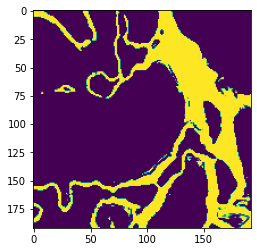

In [77]:
plt.imshow(generator(x)[0,0,:,:])

In [78]:
from google.colab import files

np.savetxt("bw.csv", generator(x)[0,0,:,:], delimiter=",")
files.download('bw.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>